In [176]:
## Importing standard modules
import sys
import pandas as pd
import numpy as np
import time
from datetime import date, datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

## Importing hand-made modules
scraper_modules_path = 'C:/Users/ABour/Desktop/Energy Systems & Data Analytics/Modules/Energy Analysis - Aidan/Visualisation Challenge/custom_modules'
if scraper_modules_path not in sys.path:
    sys.path.append(scraper_modules_path)

import electric_insights_scraper as EI

## Data Retrieval & Formatting
### Retrieval

In [180]:
## Cycling through on a weekly basis with time delay

start_date = date(2009, 1, 1)
end_cycle_date = date(2018, 10, 1)

scrape_EI = False
read_EI_pickle = True

if scrape_EI == True:
    df_EI = pd.DataFrame()
    while start_date < end_cycle_date:
        end_date = start_date + timedelta(days=7)
        df_EI_temp = EI.date_range_to_proc_EI_df(start_date, end_date) # Creating df
        df_EI = df_EI.append(df_EI_temp)
        start_date = end_date
        time.sleep(5)
        
    df_EI.to_csv('data/EI.csv') # Saving df as csv
    df_EI.to_pickle('data/df_EI.pkl') # Saving df as pickle

if read_EI_pickle == True:
    df_EI = pd.read_pickle('data/df_EI.pkl')
                              
df_EI.head()

,biomass,coal,demand,gas,hydro,nuclear,solar,wind,dutch,french,irish,pumped_storage
UTC,,,,,,,,,,,,
2009-01-01 00:00:00,0.0,17.650,38.329,11.900,0.246,6.973,0.0,0.148,0.0,1.977,-0.161,-0.404
2009-01-01 00:30:00,0.0,17.770,38.461,12.031,0.245,6.968,0.0,0.157,0.0,1.977,-0.160,-0.527
2009-01-01 01:00:00,0.0,18.070,37.986,11.754,0.246,6.970,0.0,0.147,0.0,1.977,-0.160,-1.018
2009-01-01 01:30:00,0.0,18.022,36.864,11.162,0.246,6.969,0.0,0.148,0.0,1.746,-0.160,-1.269
2009-01-01 02:00:00,0.0,17.998,36.180,10.812,0.246,6.960,0.0,0.160,0.0,1.730,-0.160,-1.566


### Formatting

In [58]:
end_trim_date = datetime(2018, 8, 31, 23, 30)
df_EI = df_EI[df_EI.index<=pd.to_datetime(end_trim_date)]

In [59]:
def create_dt_range(df_EI):
    time_start = df_EI.index.values[0]
    time_end = df_EI.index.values[-1]
    return pd.date_range(time_start, time_end, freq="30min")

def returnNotMatches(a, b):
    a = set(a)
    b = set(b)
    return [list(b - a), list(a - b)]

dt_idx = create_dt_range(df_EI)
non_matched = returnNotMatches(df_EI.index.values, dt_idx.values)
dt_idx.shape[0] - df_EI.shape[0]

19

In [183]:
## Next translate the list to a query for the API for those settlement times

non_matched[0].sort()
non_matched[0]

[numpy.datetime64('2009-10-25T01:00:00.000000000'),
 numpy.datetime64('2009-10-25T01:30:00.000000000'),
 numpy.datetime64('2010-10-31T01:00:00.000000000'),
 numpy.datetime64('2010-10-31T01:30:00.000000000'),
 numpy.datetime64('2011-10-30T01:00:00.000000000'),
 numpy.datetime64('2011-10-30T01:30:00.000000000'),
 numpy.datetime64('2012-10-28T01:00:00.000000000'),
 numpy.datetime64('2012-10-28T01:30:00.000000000'),
 numpy.datetime64('2013-10-27T01:00:00.000000000'),
 numpy.datetime64('2013-10-27T01:30:00.000000000'),
 numpy.datetime64('2014-10-26T01:00:00.000000000'),
 numpy.datetime64('2014-10-26T01:30:00.000000000'),
 numpy.datetime64('2015-10-25T01:00:00.000000000'),
 numpy.datetime64('2015-10-25T01:30:00.000000000'),
 numpy.datetime64('2016-10-30T01:00:00.000000000'),
 numpy.datetime64('2016-10-30T01:30:00.000000000'),
 numpy.datetime64('2017-07-12T23:30:00.000000000'),
 numpy.datetime64('2017-10-29T01:00:00.000000000'),
 numpy.datetime64('2017-10-29T01:30:00.000000000')]

All but one of the missing datetimes is due to missing the 49th and 50th settlement periods in the switch from DST to GMT. As this occurs at 1 in the morning when solar is negligible the missing values will be ignored.

## Visualisations
### The Duck Curve

In [184]:
years = [2009+num for num in list(range(0, 10))]

df_demand_Q2 = pd.DataFrame()

for year in years:
    df_temp = df_EI[datetime(year, 4, 1, 0, 0):datetime(year, 6, 30, 23, 30)].copy()
    df_temp['time'] = df_temp.index.time

    df_demand_Q2[f'{str(year)}'] = df_temp.groupby('time').mean().demand - df_temp.groupby('time').mean().solar
    
df_demand_Q2.to_csv('data/demand_Q2.csv') # Saving df as csv
df_demand_Q2.head()

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
time,,,,,,,,,,
00:00:00,26.770626,26.929066,25.869571,26.676275,26.325791,24.876978,24.374934,24.051637,23.854659,23.732527
00:30:00,26.822901,26.992396,25.814747,26.919341,26.579132,24.926692,24.527198,24.247560,23.920703,23.786209
01:00:00,26.435912,26.643077,25.402802,26.622505,26.312912,24.593473,24.257681,23.977934,23.661659,23.580802
01:30:00,26.051868,26.292879,25.030374,26.288286,26.004022,24.226473,23.908451,23.626725,23.312802,23.254220
02:00:00,25.701780,25.986659,24.751604,25.951462,25.723978,23.933066,23.620890,23.347286,23.072934,22.999692


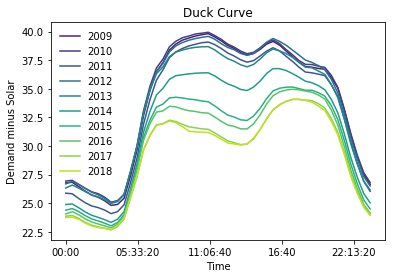

In [163]:
color_list = sns.color_palette("viridis", 10)
cmap = dict(zip(years, color_list))

for year in years:
    plt.plot(df_demand_Q2.index, df_demand_Q2[f'{year}'], label=f'{year}', color=cmap[year])

plt.xlabel('Time')
plt.ylabel('Demand minus Solar')
plt.title("Duck Curve")

plt.legend(frameon=False)

plt.show()

In [185]:
df_demand_Q2_long = pd.melt(df_demand_Q2.reset_index(),id_vars=['time'],var_name='year', value_name='values')
df_demand_Q2_long.to_csv('data/demand_Q2_long.csv') # Saving df as csv

df_demand_Q2_long.head() # for R

,time,year,values
0,00:00:00,2009,26.770626
1,00:30:00,2009,26.822901
2,01:00:00,2009,26.435912
3,01:30:00,2009,26.051868
4,02:00:00,2009,25.701780


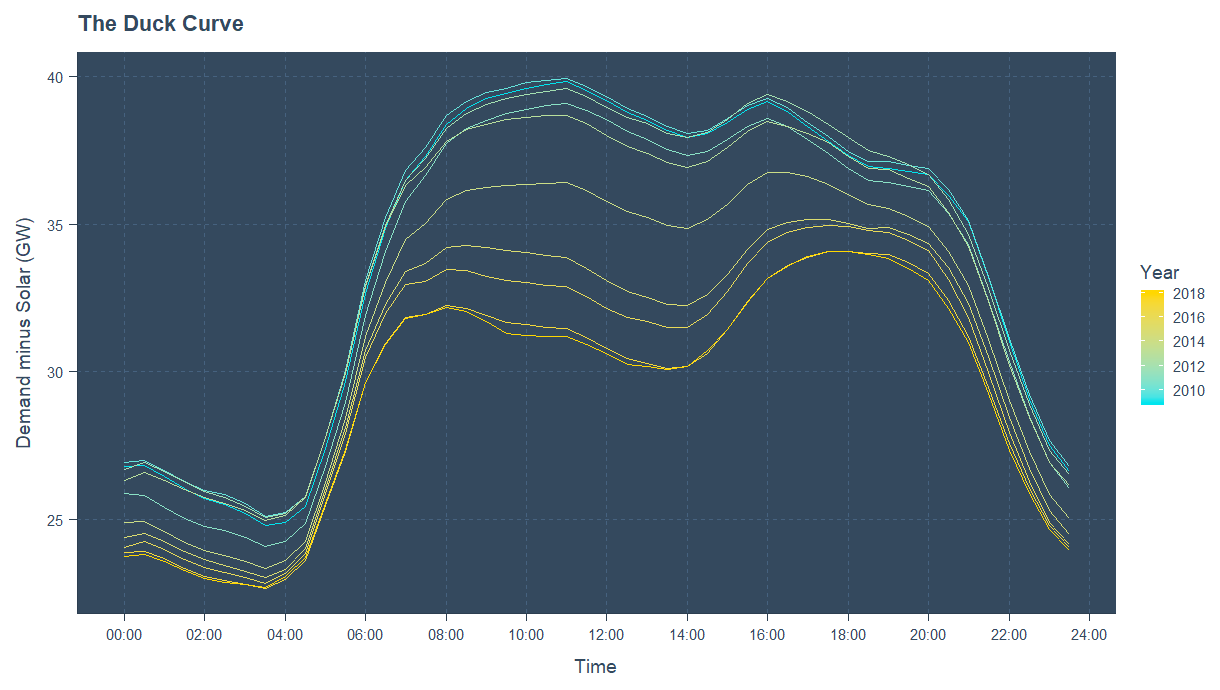

In [179]:
Image(filename='the_duck_curve.png') # From R plot